In [1]:
%matplotlib inline

In [2]:
import firedrake
from clawpack.geoclaw import dtopotools

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si
import urllib.request

In [4]:
from adapt_utils.case_studies.tohoku.options import *
from adapt_utils.unsteady.swe.tsunami.conversion import utm_to_lonlat
from adapt_utils.unsteady.swe.tsunami.solver import AdaptiveTsunamiProblem

In this notebook we generate a source using an array of Okada functions, each of which corresponds to a subfault.
In the work of [1] a 19 x 10 array is used.
We shall collect data on-the-fly from [this webpage](http://ji.faculty.geol.ucsb.edu/big_earthquakes/2011/03/0311_v3/result_c/static_out).
The collected data includes latitudes, longitudes and depths of each subfault, as well as strike, slip, dip and rake parameter values.
Each Okada function has length 25km and width 20km.
Note that the data also includes initial times, as well as rise and end times for each subfault, although we do not use those here.

An alternative approach is to use the GCMT parameters for earthquake found at the [Global Centroid Moment Tensor Project database](http://www.globalcmt.org/CMTsearch.html).

[1] _Focal mechanism and slip history of the 2011 Mw 9.1 off the Pacific coast of Tohoku Earthquake, constrained with teleseismic body and surface waves_ (2012), Shao et al.

In [5]:
url = "http://ji.faculty.geol.ucsb.edu/big_earthquakes/2011/03/0311_v3/result_c/static_out"
with urllib.request.urlopen(url) as fp:
    data_bytes = fp.read()                # read webpage as bytes
    data_str = data_bytes.decode("utf8")  # convert to a string

In [6]:
controls = ('latitude', 'longitude', 'depth', 'slip', 'rake', 'strike', 'dip')
source_parameters = {}
for control in controls:
    source_parameters[control] = []
source_parameters['length'] = []
source_parameters['width'] = []

i = 0
for line in data_str.split('\n'):
    i += 1
    if i <= 15:
        continue
    for word, control in zip(line.split(), controls):
        val = float(word)
        if control == 'slip':
            val /= 100  # convert from cm to m
        if control == 'depth':
            val *= 1000  # convert from km to m
        source_parameters[control].append(val)
    source_parameters['length'].append(25.0e+03)
    source_parameters['width'].append(20.0e+03)

In [7]:
mean_source_parameters = {  # source is based on a 19x10 grid
    'length': 19*source_parameters['length'][0],
    'width': 10*source_parameters['width'][0],
}
for control in controls:
    mean_source_parameters[control] = np.mean(source_parameters[control])
    print("mean {:10s}:  {:.2f}".format(control, mean_source_parameters[control]))
print("total length   :  {:.2f}".format(mean_source_parameters['length']))
print("total width    :  {:.2f}".format(mean_source_parameters['width']))

mean latitude  :  37.89
mean longitude :  142.64
mean depth     :  24987.20
mean slip      :  12.70
mean rake      :  67.38
mean strike    :  198.00
mean dip       :  10.00
total length   :  475000.00
total width    :  200000.00


Function to create a fault from Okada control parameters GeoCLAW's `Fault` and `Subfault` classes.

In [8]:
def set_fault(source_parameters, coordinate_specification="centroid", verbose=True):
    """
    Create a fault from a list of subfault parameters.
    
    :kwarg coordinate_specification: choose from 'top center', 'bottom center', 'centroid', 'noaa sift' and
        'top upstrike'.
    :kwarg verbose: toggle printing of statistics.
    :return: a Geoclaw :class:`Fault` object comprised of :class:`Subfault`s constructed from the inputs.
    """
    num_subfaults = len(source_parameters['latitude'])
    for var in source_parameters:
        assert len(source_parameters[var]) == num_subfaults
    
    # Create subfaults
    subfaults = [dtopotools.SubFault() for i in range(num_subfaults)]
    msg = "subfault {:d}: shear modulus {:4.1e} Pa, seismic moment is {:4.1e}"
    for i in range(num_subfaults):
        for var in source_parameters:
            subfaults[i].__setattr__(var, source_parameters[var][i])
        subfaults[i].coordinate_specification = coordinate_specification
        if verbose:
            print(msg.format(i, subfaults[i].mu, subfaults[i].Mo()))
        
    # Create fault
    fault = dtopotools.Fault(subfaults=subfaults)
    if verbose:
        print("this corresponds to an earthquake with moment magnitude {:4.1e}".format(fault.Mw()))
        
    return fault

In [9]:
fault = set_fault(source_parameters, coordinate_specification='centroid')

subfault 0: shear modulus 4.0e+10 Pa, seismic moment is 2.5e+20
subfault 1: shear modulus 4.0e+10 Pa, seismic moment is 4.0e+20
subfault 2: shear modulus 4.0e+10 Pa, seismic moment is 5.5e+20
subfault 3: shear modulus 4.0e+10 Pa, seismic moment is 6.6e+20
subfault 4: shear modulus 4.0e+10 Pa, seismic moment is 6.9e+20
subfault 5: shear modulus 4.0e+10 Pa, seismic moment is 7.0e+20
subfault 6: shear modulus 4.0e+10 Pa, seismic moment is 6.9e+20
subfault 7: shear modulus 4.0e+10 Pa, seismic moment is 6.3e+20
subfault 8: shear modulus 4.0e+10 Pa, seismic moment is 4.9e+20
subfault 9: shear modulus 4.0e+10 Pa, seismic moment is 3.4e+20
subfault 10: shear modulus 4.0e+10 Pa, seismic moment is 2.2e+20
subfault 11: shear modulus 4.0e+10 Pa, seismic moment is 1.3e+20
subfault 12: shear modulus 4.0e+10 Pa, seismic moment is 4.8e+19
subfault 13: shear modulus 4.0e+10 Pa, seismic moment is 2.1e+18
subfault 14: shear modulus 4.0e+10 Pa, seismic moment is 7.3e+18
subfault 15: shear modulus 4.0e+10 

In [10]:
x = np.linspace(138, 148, 201)
y = np.linspace(32., 42, 201)
times = [1.0]

In [11]:
fault.create_dtopography(x, y, times)
dtopo = fault.dtopo

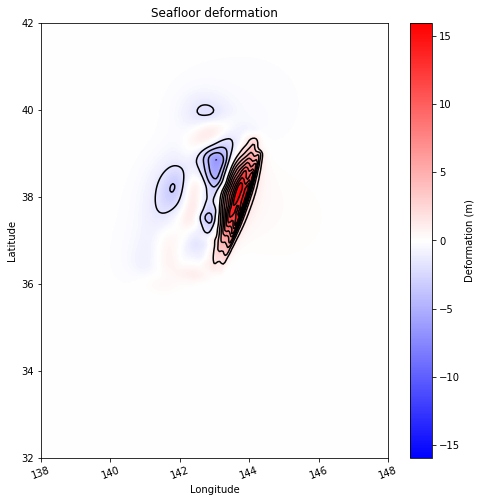

In [12]:
fig, axes = plt.subplots(figsize=(8, 8))
dtopo.plot_dZ_colors(t=1.0, axes=axes);
axes.set_xlabel('Longitude');
axes.set_ylabel('Latitude');

In [13]:
# # centre_x, centre_y = 0.7e+06, 4.2e+06
# # centre = utm_to_lonlat(centre_x, centre_y, 54, northern=True)
# centre = (143.05, 37.52)

In [14]:
# control_parameters = [
#     (
#         5.0e+03,    # depth at top of fault
#         560e+03,    # fault plane length
#         240e+03,    # fault plane width
#         20.0,       # slip (average displacement)
#         203,        # strike (angle from north)
#         10,         # dip (angle to horizontal)
#         88,         # rake (slip of one block compared to another)
#         centre[0],  # longitude of top-centre of fault plane
#         centre[1],  # latitude of top-centre of fault plane
#     ),
# ]

Specify initial guess control parameters and pass to `Options` constructor

In [15]:
op = TohokuOptions(level=2)
op.get_lonlat_mesh()

# op = TohokuOkadaOptions(level=2, control_parameters=control_parameters)  # TODO

# op = TohokuGaussianBasisOptions(level=0, control_parameters=[1.0, ])

Interpolate the deformation into a $\mathbb P1$ space

In [16]:
surf_interp = si.interp2d(x, y, fault.dtopo.dZ)

In [17]:
P1 = firedrake.FunctionSpace(op.lonlat_mesh, "CG", 1)
surf = firedrake.Function(P1)
for i, xy in enumerate(op.lonlat_mesh.coordinates.dat.data):
    surf.dat.data[i] = surf_interp(*xy)

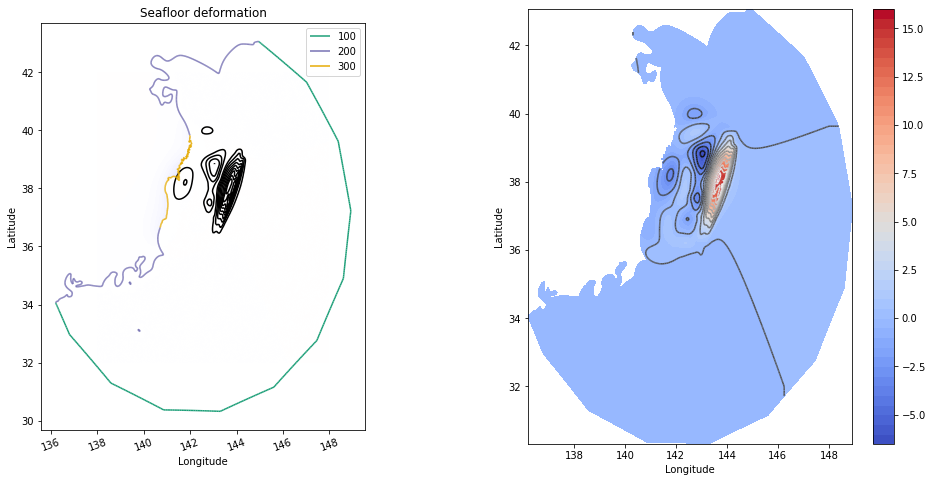

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

dtopo.plot_dZ_colors(t=1.0, axes=axes[0]);
firedrake.triplot(op.lonlat_mesh, interior_kw={'color': 'w'}, axes=axes[0]);
axes[0].legend();
axes[0].set_xlabel('Longitude');
axes[0].set_ylabel('Latitude');
axes[0].images[-1].colorbar.remove();

fig.colorbar(firedrake.tricontourf(surf, cmap='coolwarm', axes=axes[1], levels=50), ax=axes[1]);
firedrake.tricontour(surf, cmap='gray', axes=axes[1], levels=20);
axes[1].set_xlabel('Longitude');
axes[1].set_ylabel('Latitude');

For simulations we need the displacement in UTM coordinates

In [36]:
op.family = 'dg-cg'
op.save_timeseries = True

swp = AdaptiveTsunamiProblem(op)
surf = firedrake.Function(swp.P1[0])
for i, xy in enumerate(op.lonlat_mesh.coordinates.dat.data):
    surf.dat.data[i] = surf_interp(*xy)
u, eta = swp.fwd_solutions[0].split()
eta.interpolate(surf);

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fd3ace65358>, FiniteElement('Lagrange', triangle, 2, variant='equispaced'), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 604)

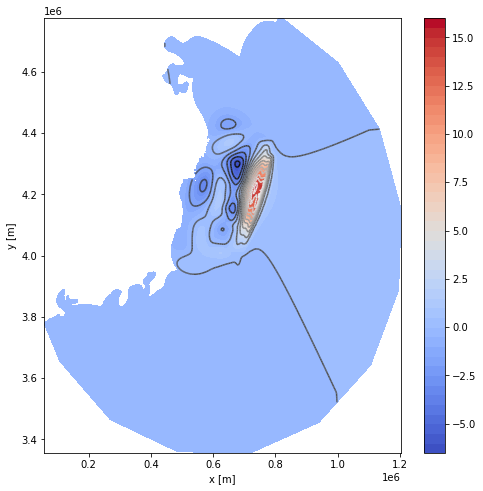

In [37]:
fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(firedrake.tricontourf(surf, cmap='coolwarm', axes=axes, levels=50), ax=axes);
firedrake.tricontour(surf, cmap='gray', axes=axes, levels=20);
axes.set_xlabel('x [m]');
axes.set_ylabel('y [m]');

Let's run a simulation with this initial surface and see what the gauge timeseries look like.

In [38]:
swp.setup_solver_forward(0)
swp.solve_forward_step(0)

#### TODO: Setup strong residual for Crank-Nicolson
 0  FORWARD SOLVE mesh  1/ 1  time     0.00
 0  FORWARD SOLVE mesh  1/ 1  time    60.00
 0  FORWARD SOLVE mesh  1/ 1  time   120.00
 0  FORWARD SOLVE mesh  1/ 1  time   180.00
 0  FORWARD SOLVE mesh  1/ 1  time   240.00
 0  FORWARD SOLVE mesh  1/ 1  time   300.00
 0  FORWARD SOLVE mesh  1/ 1  time   360.00
 0  FORWARD SOLVE mesh  1/ 1  time   420.00
 0  FORWARD SOLVE mesh  1/ 1  time   480.00
 0  FORWARD SOLVE mesh  1/ 1  time   540.00
 0  FORWARD SOLVE mesh  1/ 1  time   600.00
 0  FORWARD SOLVE mesh  1/ 1  time   660.00
 0  FORWARD SOLVE mesh  1/ 1  time   720.00
 0  FORWARD SOLVE mesh  1/ 1  time   780.00
 0  FORWARD SOLVE mesh  1/ 1  time   840.00
 0  FORWARD SOLVE mesh  1/ 1  time   900.00
 0  FORWARD SOLVE mesh  1/ 1  time   960.00
 0  FORWARD SOLVE mesh  1/ 1  time  1020.00
 0  FORWARD SOLVE mesh  1/ 1  time  1080.00
 0  FORWARD SOLVE mesh  1/ 1  time  1140.00
 0  FORWARD SOLVE mesh  1/ 1  time  1200.00
 0  FORWARD SOLVE mesh  

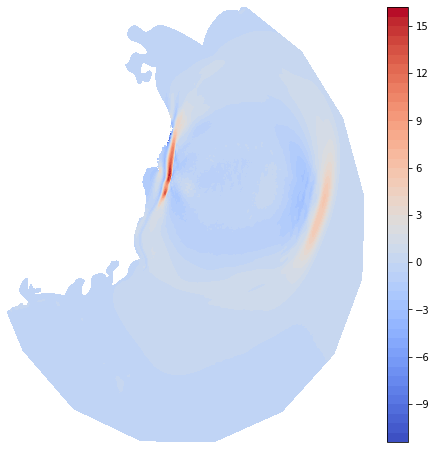

In [40]:
fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(firedrake.tricontourf(eta, cmap='coolwarm', levels=50, axes=axes), ax=axes);
axes.axis(False);

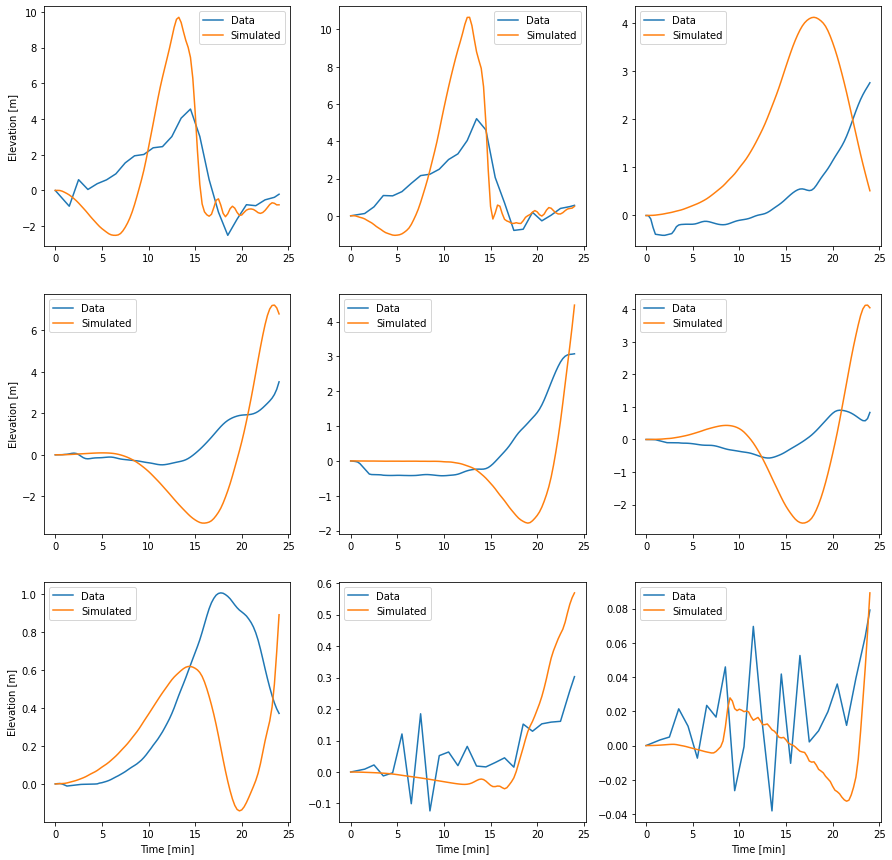

In [51]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

times = np.array(op.times)/60
for i, gauge in enumerate(op.gauges):
    ax = axes[i // 3, i % 3]
    ax.plot(times, op.gauges[gauge]['data'], label='Data')
    ax.plot(times, op.gauges[gauge]['timeseries'], label='Simulated')
    if i // 3 == 2:
        ax.set_xlabel('Time [min]')
    if i % 3 == 0:
        ax.set_ylabel('Elevation [m]')
    ax.legend()

Clearly the fit is not good, with the elevation being far too large in some cases.
This is likely because we have assumed that all 190 subfaults trigger at the same instant.

In order to do the inversion using pyadjoint we need to build everything using things which can be annotated.

In [24]:
# class Fault(object):
#     """Based on code from `geoclaw/src/python/geoclaw/dtopotools.py`."""
#     def __init__(self, subfaults=None, input_units={}, coordinate_specification=None):
#         raise NotImplementedError  # TODO